# 6. Validación y Selección del Modelo
OLS, Reach, Lasso

## 6.1. Importacion de librerias

In [1]:
# Librerías científicas básicas
import numpy as np
import pandas as pd
import scipy.stats as stats

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos estadísticos
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
 
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

## 6.2. Lectura de datos

In [2]:
df = pd.read_csv('../data/hour_clean.csv', sep =";")

## 6.3 Split data set (Training and test)
En este apartado separaremos los datos en un 70% para entremaniento de los modelos y un 30% para testing de los mismos.

In [3]:
np.random.seed(42)
train, test = train_test_split(df, train_size=0.7, test_size=0.3, random_state=42) ## aqui separamos uno en 70% del data set y otro 30%, la separacion es aleatoria
print("tamaño set de entrenemaiento ", train.shape)
print("tamaño set de prueba ", test.shape)

tamaño set de entrenemaiento  (12165, 20)
tamaño set de prueba  (5214, 20)


## 6.4 Aplicacion de Ridge y Lasso
Aqui se aplicara ridge y lasso para encontrar si el modelo requiere de sus correcciones.

In [4]:
# 1. Subdivisión del conjunto de entrenamiento
X_train = train[['yr', 'temp', 'hum', 'windspeed', 'peak_hour', 'hr_sin', 'hr_cos',
       'month_sin', 'season_2', 'season_3', 'season_4', 'weathersit_2',
       'weathersit_3', 'holiday_1']]
y_train = train['cnt']

X_test = test[['yr', 'temp', 'hum', 'windspeed', 'peak_hour', 'hr_sin', 'hr_cos',
       'month_sin', 'season_2', 'season_3', 'season_4', 'weathersit_2',
       'weathersit_3', 'holiday_1']]
y_test = test['cnt']

np.random.seed(42)

# split interno para elegir alpha
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_train, y_train, 
    train_size=0.8, test_size=0.2, 
    random_state=42
)
# 2. Búsqueda de alpha
alphas = np.logspace(-4, 3, 40)

# RIDGE
mejor_alpha_ridge = None
mejor_r2_ridge = -np.inf

for a in alphas:
    modelo = Ridge(alpha=a)
    modelo.fit(X_train_2, y_train_2)
    pred_val = modelo.predict(X_test_2)
    r2_val = r2_score(y_test_2, pred_val)

    if r2_val > mejor_r2_ridge:
        mejor_r2_ridge = r2_val
        mejor_alpha_ridge = a

print(f"Ridge --> Mejor alpha = {mejor_alpha_ridge:.4f} | R² validación = {mejor_r2_ridge:.4f}")

# LASSO
mejor_alpha_lasso = None
mejor_r2_lasso = -np.inf

for a in alphas:
    modelo = Lasso(alpha=a, max_iter=10000)
    modelo.fit(X_train_2, y_train_2)
    pred_val = modelo.predict(X_test_2)
    r2_val = r2_score(y_test_2, pred_val)

    if r2_val > mejor_r2_lasso:
        mejor_r2_lasso = r2_val
        mejor_alpha_lasso = a

print(f"Lasso --> Mejor alpha = {mejor_alpha_lasso:.4f} | R² validación = {mejor_r2_lasso:.4f}")

# 3. Métrica personalizada
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 4. Reentrenar con todo el train y evaluar

# Ridge final
ridge_final = Ridge(alpha=mejor_alpha_ridge)
ridge_final.fit(X_train, y_train)
ridge_pred_train = ridge_final.predict(X_train)
ridge_pred_test = ridge_final.predict(X_test)

resultados_ridge = {
    "R2 Train": r2_score(y_train, ridge_pred_train),
    "R2 Test": r2_score(y_test, ridge_pred_test),
    "RMSE Test": np.sqrt(mean_squared_error(y_test, ridge_pred_test)),
    "MAE Test": mean_absolute_error(y_test, ridge_pred_test),
    "MAPE Test (%)": mape(y_test, ridge_pred_test)
}

# Lasso final
lasso_final = Lasso(alpha=mejor_alpha_lasso, max_iter=10000)
lasso_final.fit(X_train, y_train)
lasso_pred_train = lasso_final.predict(X_train)
lasso_pred_test = lasso_final.predict(X_test)

resultados_lasso = {
    "R2 Train": r2_score(y_train, lasso_pred_train),
    "R2 Test": r2_score(y_test, lasso_pred_test),
    "RMSE Test": np.sqrt(mean_squared_error(y_test, lasso_pred_test)),
    "MAE Test": mean_absolute_error(y_test, lasso_pred_test),
    "MAPE Test (%)": mape(y_test, lasso_pred_test)
}


# 5. tabla final
df_resultados = pd.DataFrame([resultados_ridge, resultados_lasso], index=["Ridge", "Lasso"])
display(df_resultados)


Ridge --> Mejor alpha = 4.6416 | R² validación = 0.6510


Lasso --> Mejor alpha = 0.0001 | R² validación = 0.6509


,R2 Train,R2 Test,RMSE Test,MAE Test,MAPE Test (%)
Ridge,0.643332,0.643748,106.086232,79.643431,287.148603
Lasso,0.643348,0.643811,106.076904,79.668720,288.147691


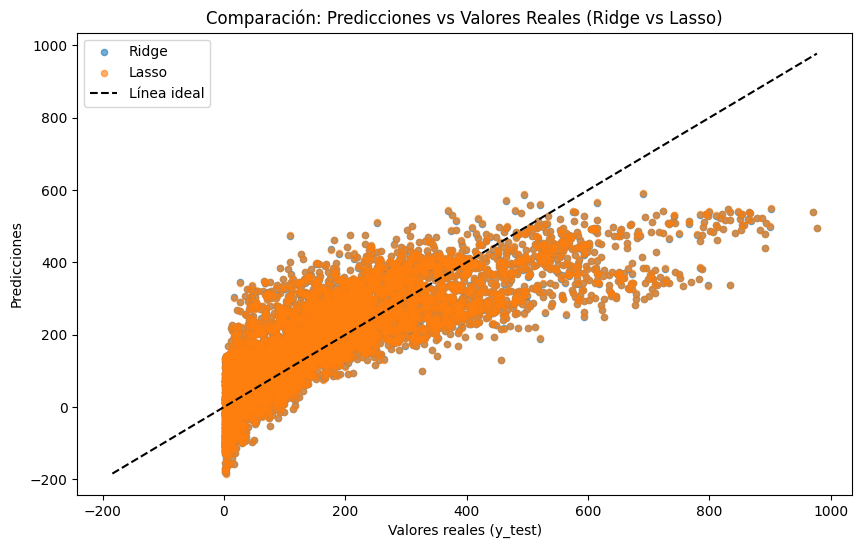

In [5]:
plt.figure(figsize=(10, 6))

# Valores reales
plt.scatter(y_test, ridge_pred_test, alpha=0.6, label="Ridge", s=20)
plt.scatter(y_test, lasso_pred_test, alpha=0.6, label="Lasso", s=20)

# Línea identidad (predicción perfecta)
min_val = min(y_test.min(), ridge_pred_test.min(), lasso_pred_test.min())
max_val = max(y_test.max(), ridge_pred_test.max(), lasso_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="Línea ideal")

plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones")
plt.title("Comparación: Predicciones vs Valores Reales (Ridge vs Lasso)")
plt.legend()
plt.show()



### 6.4.1. Interpretacion de resultados

Ridge y Lasso terminan siendo prácticamente iguales, lo que indica que:

No hay diferencia significativa en desempeño.
Cambiar entre Ridge y Lasso NO mejora el modelo.
El comportamiento sugiere que la regularización no cambia mucho la relación entre variables y demanda de bicis.

- esto es consecuente con que las variables seleccionadas no hay multicolinealidad.
- Se han realizado tansformaciones de valor sonbre las variables.
- La relacion detectada es moderada pero no fuerte.

Respecto al desempeño del **$R^2$** en test y train, el modelo generaliza bien, evitando sobre ajustes, explicando asi el 64% de la variabilidad, lo cual deja aun sin cubrir temas como interacciones entre variables climaticas, relaciones no lineales o patrones temporales.

### 6.4.2. Seleccion del modelo optimo

Ridge resulta ser más estable cuando todas las variables son relevantes y como en nuestro data set las variables ya están seleccionadas y ninguna sobra, el ruido se ha reducido previamente.

Para esto, entonces, Ridge mantivo la estructura original distribuyendo encontrando y distribuyendo las penalizaciones ($ \alpha = 4.64$)

Lo que indica que Ridge si puedo encontrar un nivel de regularizar el modelo base, **aumentando robustez y reducuiendo varianza**, aun cuando la diferencia es pequeña.

## 6.4.2 Coeficientes Modelo Ridge y OLS

Abajo la tabla indicando los coeficientes antes y despues de Ridge

In [6]:
# 1. Cargar modelo OLS
import pickle
with open("ols_model.pkl", "rb") as f:
    ols_loaded = pickle.load(f)


ols_coefs = ols_loaded.params.rename({"const": "Intercepto"})


# 2. Coeficientes Ridge

ridge_coefs = pd.Series(ridge_final.coef_, index=X_train.columns)
ridge_coefs["Intercepto"] = ridge_final.intercept_

# 3. Tabla comparativa
tabla_coef = pd.DataFrame({
    "Ridge": ridge_coefs,
    "OLS": ols_coefs
    
})

# Asegurar orden poniendo el Intercepto arriba
if "Intercepto" in tabla_coef.index:
    tabla_coef = pd.concat([
        tabla_coef.loc[["Intercepto"]],
        tabla_coef.drop("Intercepto")
    ])

tabla_coef


,Ridge,OLS
Intercepto,25.289041,23.331572
holiday_1,-31.917980,-32.335557
hr_cos,-75.032784,-74.786893
hr_sin,-83.735378,-83.408825
hum,-67.837270,-68.671321
month_sin,-9.797698,-8.980338
peak_hour,160.411377,160.822992
season_2,46.369353,45.173595
season_3,24.298481,23.046767
season_4,56.445321,56.951170
